<a href="https://colab.research.google.com/github/heruu-1/FIN/blob/main/TugasFIN_Analisis_Saham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Library

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import joblib

##Data Preparation

In [ ]:
# Load the data
try:
    df = pd.read_csv('stock_price (1).csv')
except FileNotFoundError:
    print("Error")
    df = pd.DataFrame() # Initialize empty DataFrame to avoid errors later.

if not df.empty:
    # Convert the 'Date' column to string type first
    df['Date'] = df['Date'].astype(str)

    # Correct the date format
    df['Date'] = df['Date'].str.zfill(8)  # Ensure 8 digits
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d', errors='coerce')

    # Display the first few rows and info
    display(df.head())
    display(df.info())

,Date,Open,High,Low,Close,Volume,AdjustedClose
0,2015-05-25,12475.0,12525.0,12300.0,12350.0,21901500,2409.729
1,2015-05-26,12200.0,12500.0,12200.0,12375.0,14906500,2414.607
2,2015-05-27,12025.0,12325.0,11950.0,11950.0,29266400,2331.681
3,2015-05-28,12000.0,12075.0,11825.0,11825.0,29142400,2307.291
4,2015-05-29,11700.0,11875.0,11700.0,11775.0,63172200,2297.535


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2414 non-null   datetime64[ns]
 1   Open           2414 non-null   float64       
 2   High           2414 non-null   float64       
 3   Low            2414 non-null   float64       
 4   Close          2414 non-null   float64       
 5   Volume         2414 non-null   int64         
 6   AdjustedClose  2414 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 132.1 KB


None

## Data cleaning



Missing Values after outlier handling:
 Date             0
Open             0
High             0
Low              0
Close            0
Volume           0
AdjustedClose    0
dtype: int64

No missing values found after outlier handling.

Descriptive Statistics after cleaning:
                                 Date        Open         High          Low  \
count                           2414  2414.00000  2414.000000  2414.000000   
mean   2020-05-15 11:18:50.405965312  5583.48488  5646.975973  5542.707125   
min              2015-05-25 00:00:00  2250.00000  2270.000000  2160.000000   
25%              2017-11-17 18:00:00  3940.00000  3970.000000  3880.000000   
50%              2020-05-13 12:00:00  4505.00000  4550.000000  4460.000000   
75%              2022-11-03 18:00:00  6237.50000  6300.000000  6200.000000   
max              2025-05-22 00:00:00  9683.75000  9795.000000  9680.000000   
std                              NaN  2433.71407  2461.341163  2451.604664   

             Close  

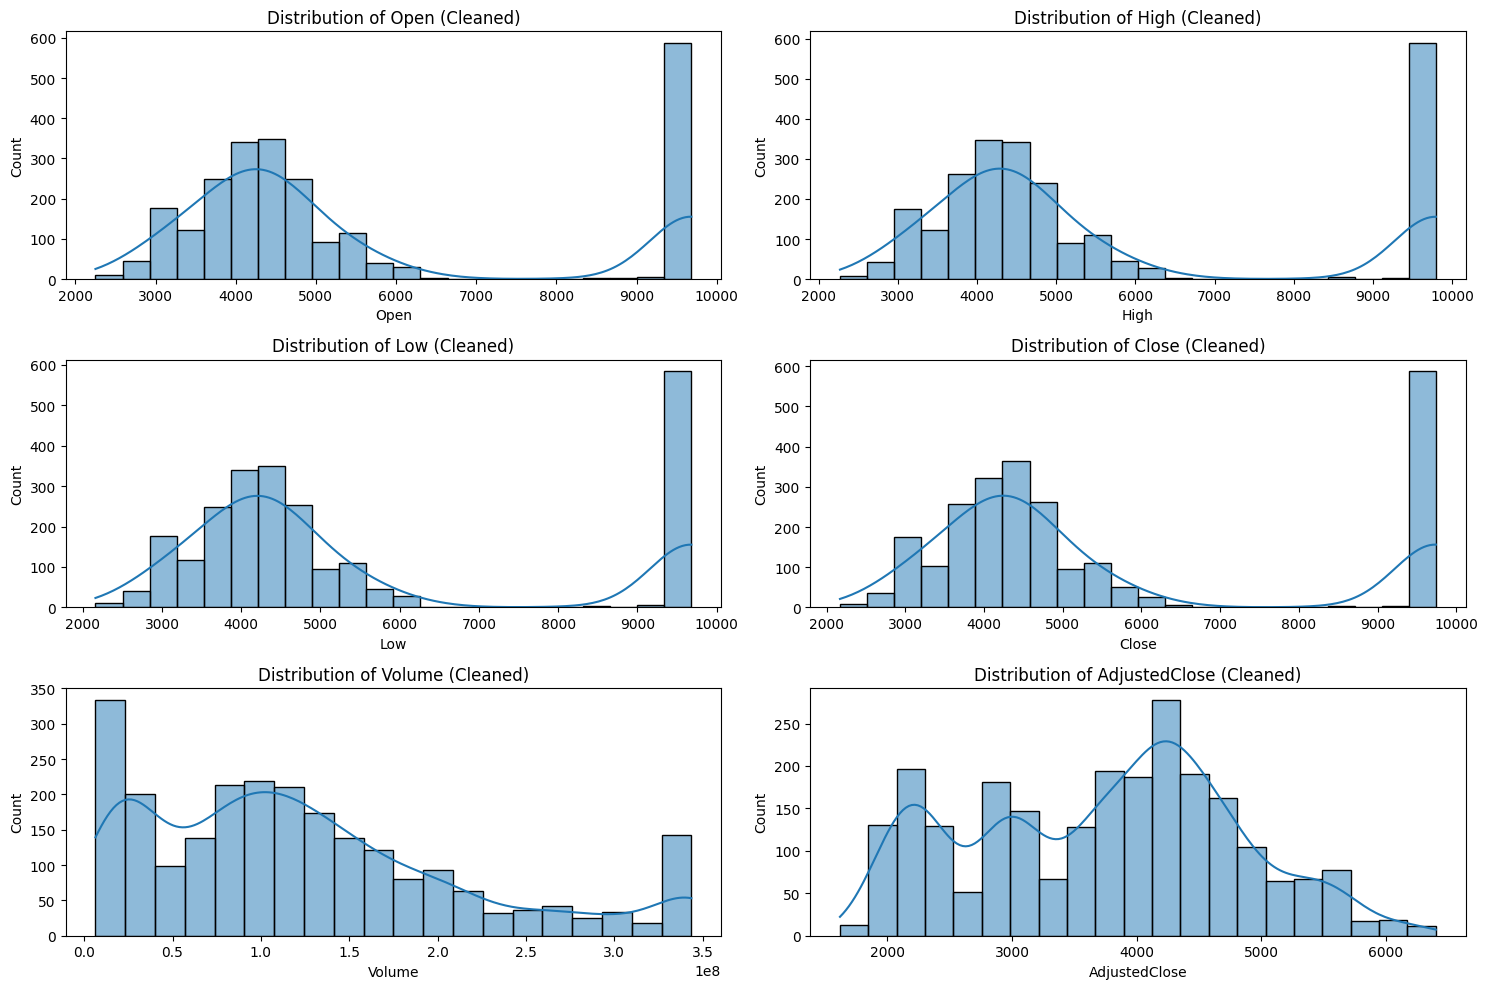

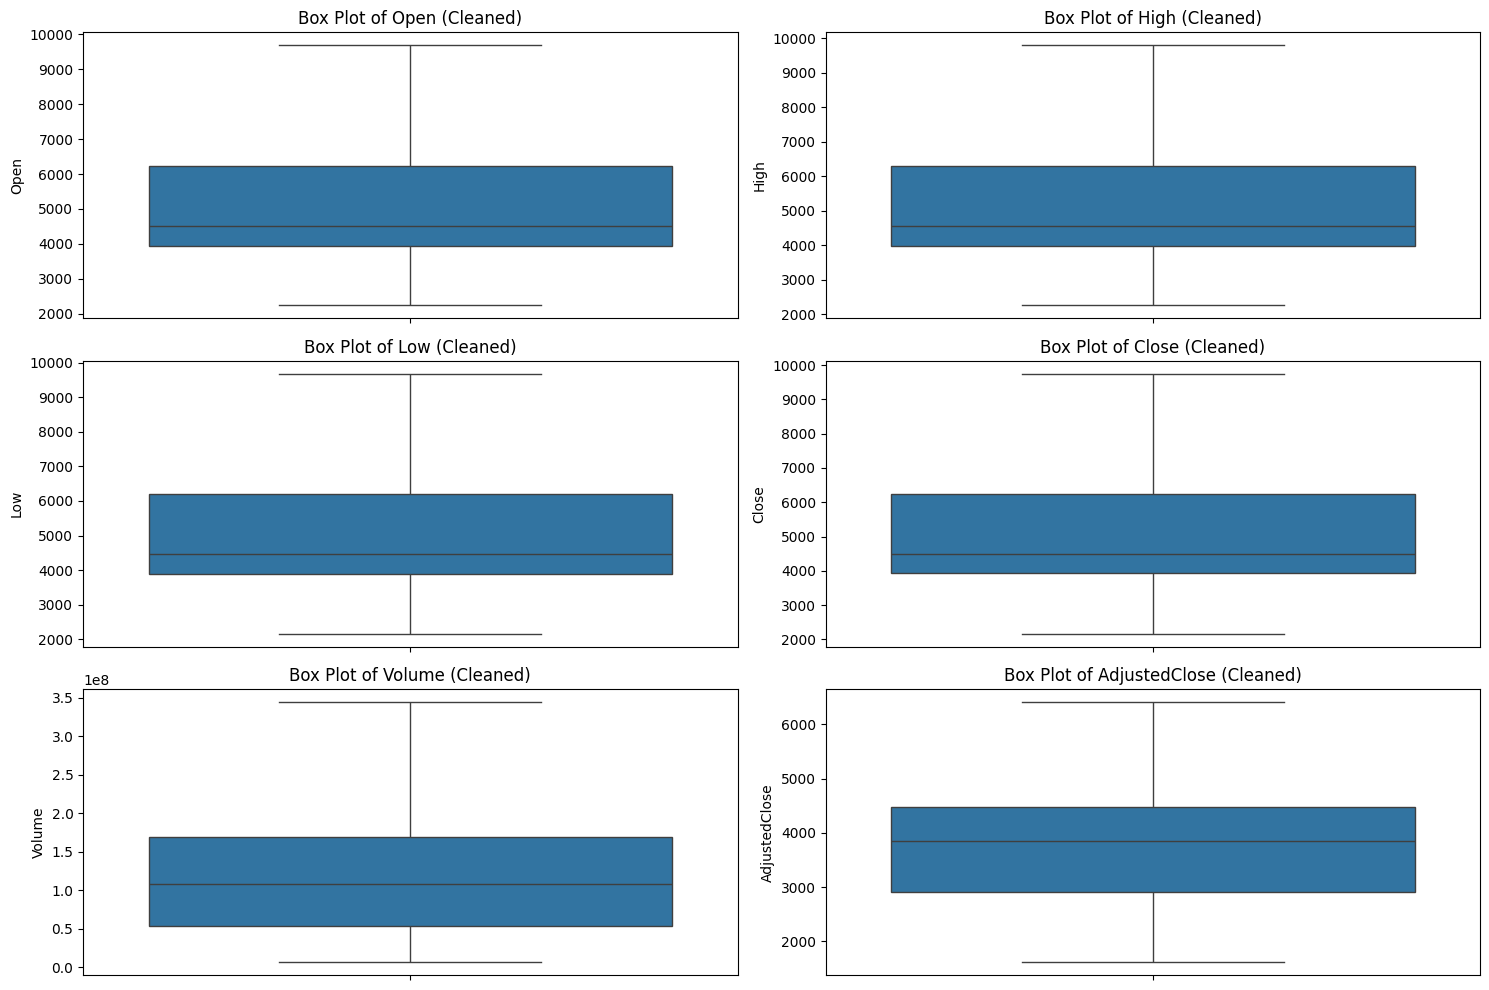

In [ ]:
# Outlier handling using IQR method
numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'AdjustedClose']
for col in numerical_features:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

# Check for missing values after outlier handling
missing_values = df.isnull().sum()
print("\nMissing Values after outlier handling:\n", missing_values)
if missing_values.any():
    # Impute missing values using mean for numerical features
    for col in numerical_features:
        if df[col].isnull().any():
            df[col].fillna(df[col].mean(), inplace=True)
else:
    print("\nNo missing values found after outlier handling.")

# Data validation
print("\nDescriptive Statistics after cleaning:\n", df.describe())

# Visualizations
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col} (Cleaned)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features):
    plt.subplot(3, 2, i + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col} (Cleaned)')
plt.tight_layout()
plt.show()


## Feature engineering


In [ ]:
# Feature Engineering from Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['DayOfYear'] = df['Date'].dt.dayofyear

# Technical Indicators
# 1. Simple Moving Average (SMA)
window_size = 20  # Example window size, adjust as needed
df['SMA_20'] = df['Close'].rolling(window=window_size).mean()

# 2. Exponential Moving Average (EMA)
df['EMA_20'] = df['Close'].ewm(span=window_size, adjust=False).mean()


# Display first few rows and DataFrame info
display(df.head())
display(df.info())

,Date,Open,High,Low,Close,Volume,AdjustedClose,Year,Month,DayOfWeek,DayOfYear,SMA_20,EMA_20
0,2015-05-25,9683.75,9795.0,9680.0,9741.25,21901500,2409.729,2015,5,0,145,NaN,9741.25
1,2015-05-26,9683.75,9795.0,9680.0,9741.25,14906500,2414.607,2015,5,1,146,NaN,9741.25
2,2015-05-27,9683.75,9795.0,9680.0,9741.25,29266400,2331.681,2015,5,2,147,NaN,9741.25
3,2015-05-28,9683.75,9795.0,9680.0,9741.25,29142400,2307.291,2015,5,3,148,NaN,9741.25
4,2015-05-29,9683.75,9795.0,9680.0,9741.25,63172200,2297.535,2015,5,4,149,NaN,9741.25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2414 entries, 0 to 2413
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           2414 non-null   datetime64[ns]
 1   Open           2414 non-null   float64       
 2   High           2414 non-null   float64       
 3   Low            2414 non-null   float64       
 4   Close          2414 non-null   float64       
 5   Volume         2414 non-null   int64         
 6   AdjustedClose  2414 non-null   float64       
 7   Year           2414 non-null   int32         
 8   Month          2414 non-null   int32         
 9   DayOfWeek      2414 non-null   int32         
 10  DayOfYear      2414 non-null   int32         
 11  SMA_20         2395 non-null   float64       
 12  EMA_20         2414 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int32(4), int64(1)
memory usage: 207.6 KB


None

## Data splitting

In [ ]:
# Define the split ratio
train_ratio = 0.8
split_index = int(len(df) * train_ratio)

# Split the data into training and testing sets
df_train = df[:split_index]
df_test = df[split_index:]

# Display the shapes of the resulting DataFrames
print("Shape of training set:", df_train.shape)
print("Shape of testing set:", df_test.shape)

display(df_train.head())
display(df_test.head())

Shape of training set: (1931, 13)
Shape of testing set: (483, 13)


,Date,Open,High,Low,Close,Volume,AdjustedClose,Year,Month,DayOfWeek,DayOfYear,SMA_20,EMA_20
0,2015-05-25,9683.75,9795.0,9680.0,9741.25,21901500,2409.729,2015,5,0,145,NaN,9741.25
1,2015-05-26,9683.75,9795.0,9680.0,9741.25,14906500,2414.607,2015,5,1,146,NaN,9741.25
2,2015-05-27,9683.75,9795.0,9680.0,9741.25,29266400,2331.681,2015,5,2,147,NaN,9741.25
3,2015-05-28,9683.75,9795.0,9680.0,9741.25,29142400,2307.291,2015,5,3,148,NaN,9741.25
4,2015-05-29,9683.75,9795.0,9680.0,9741.25,63172200,2297.535,2015,5,4,149,NaN,9741.25


,Date,Open,High,Low,Close,Volume,AdjustedClose,Year,Month,DayOfWeek,DayOfYear,SMA_20,EMA_20
1931,2023-05-08,5250.0,5250.0,5050.0,5100.0,107804200,5100.0,2023,5,0,128,4984.25,5017.880770
1932,2023-05-09,5050.0,5125.0,5025.0,5125.0,103015100,5125.0,2023,5,1,129,5004.00,5028.082602
1933,2023-05-10,5075.0,5150.0,5050.0,5150.0,108419000,5150.0,2023,5,2,130,5021.50,5039.693783
1934,2023-05-11,5175.0,5175.0,5100.0,5150.0,85625400,5150.0,2023,5,3,131,5038.00,5050.199137
1935,2023-05-12,5100.0,5175.0,5100.0,5150.0,77156700,5150.0,2023,5,4,132,5054.00,5059.703981


## Model training


In [ ]:
# Prepare the data for Prophet
prophet_df = df_train[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

# Initialize and train the Prophet model
model = Prophet()
model.fit(prophet_df)

# Save the trained model
import joblib
joblib.dump(model, 'prophet_model.joblib')

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoz_jitld/u4a2hdgp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpoz_jitld/wp07il7f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5939', 'data', 'file=/tmp/tmpoz_jitld/u4a2hdgp.json', 'init=/tmp/tmpoz_jitld/wp07il7f.json', 'output', 'file=/tmp/tmpoz_jitld/prophet_modeldqb976hl/prophet_model-20250522110018.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
11:00:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
11:00:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


['prophet_model.joblib']

## Data visualization

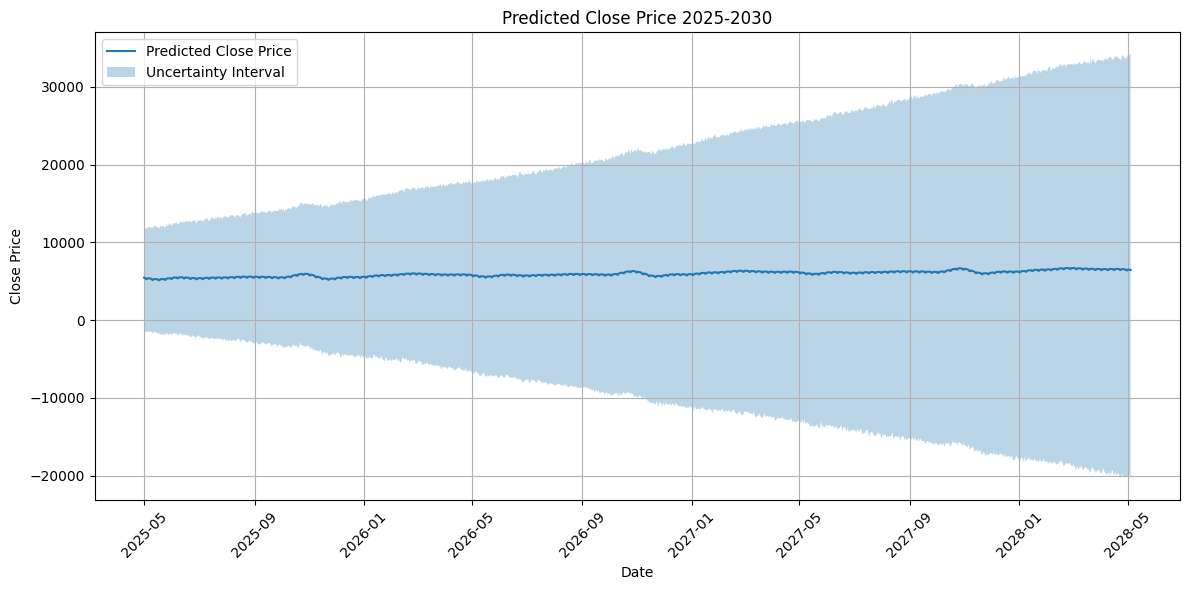

In [ ]:
# Load the trained Prophet model
model = joblib.load('prophet_model.joblib')

# Create a future dataframe extending to 2030
future = model.make_future_dataframe(periods=1826, freq='D') # approximately 5 years from 2025-05-22

# Generate predictions
forecast = model.predict(future)

# Filter predictions for 2025-2030
forecast_2025_2030 = forecast[forecast['ds'] >= '2025-05-01']

# Plot the predictions
plt.figure(figsize=(12, 6))
plt.plot(forecast_2025_2030['ds'], forecast_2025_2030['yhat'], label='Predicted Close Price')
plt.fill_between(forecast_2025_2030['ds'], forecast_2025_2030['yhat_lower'], forecast_2025_2030['yhat_upper'], alpha=0.3, label='Uncertainty Interval')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Predicted Close Price 2025-2030')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()